In [1]:
MODELS_FROM_FILE = 1
IMPORTANCES_FROM_FILE = 1

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, balanced_accuracy_score, f1_score, roc_auc_score, fbeta_score, make_scorer, roc_curve, precision_recall_curve, accuracy_score
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

    
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', None)


data_intermediate_dir = "data/intermediate/"
item_lvl_w_imp = pd.read_csv(data_intermediate_dir + "item_lvl_w_impairment.csv")

In [2]:
# Create test-based diagnosis columns

display(item_lvl_w_imp[[x for x in item_lvl_w_imp.columns if x.startswith("WISC") or x.startswith("WIAT")]].describe())
#display(item_lvl_w_imp[item_lvl_w_imp["WIAT,WIAT_Num_Stnd"] < 85])

item_lvl_w_imp["WIAT_num_score_under_85"] = (item_lvl_w_imp["WIAT,WIAT_Num_Stnd"] < 85)
item_lvl_w_imp["WIAT_word_score_under_85"] = (item_lvl_w_imp["WIAT,WIAT_Word_Stnd"] < 85)
item_lvl_w_imp["WIAT_FSIQ_under_70"] = (item_lvl_w_imp["WISC,WISC_FSIQ"] < 70)
item_lvl_w_imp["WIAT_FSIQ_bw_70_85"] = ((item_lvl_w_imp["WISC,WISC_FSIQ"] < 85) & (item_lvl_w_imp["WISC,WISC_FSIQ"] > 70))

print(item_lvl_w_imp["WIAT_num_score_under_85"].value_counts())
print(item_lvl_w_imp["WIAT_word_score_under_85"].value_counts())
print(item_lvl_w_imp["WIAT_FSIQ_under_70"].value_counts())
print(item_lvl_w_imp["WIAT_FSIQ_bw_70_85"].value_counts())

,"WIAT,WIAT_Num_Stnd","WIAT,WIAT_Word_Stnd","WISC,WISC_Coding_Scaled","WISC,WISC_FSIQ","WISC,WISC_SS_Scaled"
count,1862.000000,1862.000000,1862.000000,1862.000000,1862.000000
mean,99.609023,102.376477,8.811493,100.122986,9.621912
std,17.516851,16.994754,3.133329,16.225222,3.066155
min,46.000000,40.000000,1.000000,47.000000,1.000000
25%,88.000000,91.000000,7.000000,88.000000,8.000000
50%,98.000000,105.000000,9.000000,101.000000,10.000000
75%,110.000000,114.000000,11.000000,111.000000,12.000000
max,160.000000,153.000000,19.000000,147.000000,19.000000


False    1515
True      347
Name: WIAT_num_score_under_85, dtype: int64
False    1576
True      286
Name: WIAT_word_score_under_85, dtype: int64
False    1828
True       34
Name: WIAT_FSIQ_under_70, dtype: int64
False    1561
True      301
Name: WIAT_FSIQ_bw_70_85, dtype: int64


In [3]:
# Prepare input and ouptut column names

diag_cols = [x for x in item_lvl_w_imp.columns if x in [
    "WIAT_num_score_under_85",
    "WIAT_word_score_under_85",
    "WIAT_FSIQ_under_70",
    "WIAT_FSIQ_bw_70_85"]] # All diagnosis columns

# Input columns are all columns except Diagnosis, WIAT, and WISC columns
input_cols = [x for x in item_lvl_w_imp.columns if 
                       not x.startswith("Diag: ") 
                       and not x.startswith("WIAT")
                       and not x.startswith("WISC")
                       and not x in ["WHODAS_P,WHODAS_P_Total", "CIS_P,CIS_P_Score", "WHODAS_SR,WHODAS_SR_Score", "CIS_SR,CIS_SR_Total"]]


In [4]:
# Separate test set for all diagnoses

# Shuffle the dataset 
shuffle_df = item_lvl_w_imp.sample(frac=1)

# Define a size for the train set 
train_size = int(0.7 * len(item_lvl_w_imp))

# Split the dataset 
train_set = shuffle_df[:train_size]
test_set = shuffle_df[train_size:] # Don't touch this until the end

# Train_train and Validation set
# Define a size for your train_train set 
train_train_size = int(0.7 * len(train_set))

# Split your dataset 
train_train_set = train_set[:train_train_size]
val_set = train_set[train_train_size:]

In [5]:
def get_base_models_and_param_grids():
    
    # Define base models
    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    svc = svm.SVC()
    lr = LogisticRegression(solver="liblinear")
    
    # Impute missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    
    # Standardize data
    scaler = StandardScaler()

    # Make pipelines
    dt_pipe = make_pipeline(imputer, scaler, dt)
    rf_pipe = make_pipeline(imputer, scaler, rf)
    svc_pipe = make_pipeline(imputer, scaler, svc)
    lr_pipe = make_pipeline(imputer, scaler, lr)
    
    # Define parameter grids to search for each pipe
    from scipy.stats import loguniform, uniform
    dt_param_grid = {
        "decisiontreeclassifier__min_samples_split": np.random.randint(2, 20, 30),
        "decisiontreeclassifier__max_depth": np.random.randint(1, 30, 30),
        "decisiontreeclassifier__min_samples_leaf": np.random.randint(1, 20, 30),
        "decisiontreeclassifier__max_leaf_nodes": np.random.randint(2, 50, 30),
        "decisiontreeclassifier__criterion": ['gini', 'entropy'],
        "decisiontreeclassifier__class_weight": ['balanced', None]
    }
    rf_param_grid = {
        'randomforestclassifier__max_depth' : np.random.randint(5, 150, 30),
        'randomforestclassifier__min_samples_split': np.random.randint(2, 50, 30),
        'randomforestclassifier__n_estimators': np.random.randint(50, 400, 10),
        'randomforestclassifier__min_samples_leaf': np.random.randint(1, 20, 30),
        'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2', 0.25, 0.5, 0.75, 1.0],
        'randomforestclassifier__criterion': ['gini', 'entropy'],
        'randomforestclassifier__class_weight':["balanced", "balanced_subsample", None],
        "randomforestclassifier__class_weight": ['balanced', None]
    }
    svc_param_grid = {
        'svc__C': loguniform(1e-03, 1e+02),
        'svc__gamma': loguniform(1e-03, 1e+02),
        'svc__degree': uniform(2, 5),
        'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        "svc__class_weight": ['balanced', None]
    }
    lr_param_grid = {
        'logisticregression__C': loguniform(1e-5, 100),
        'logisticregression__penalty': ['l1', 'l2']
    }
    
    base_models_and_param_grids = [
        (dt_pipe, dt_param_grid),
        (rf_pipe, rf_param_grid),
        (svc_pipe, svc_param_grid),
        (lr_pipe, lr_param_grid),
    ]
    
    return base_models_and_param_grids

def get_best_classifier(base_model, grid, output_col):
    cv = StratifiedKFold(n_splits=3)
    rs = RandomizedSearchCV(estimator=base_model, param_distributions=grid, cv=cv, scoring="roc_auc", n_iter=100, n_jobs = -1)
    
    rs.fit(train_set[input_cols], train_set[output_col]) # On train_set, not train_train_set because do cross-validation
    
    best_estimator = rs.best_estimator_
    best_score = rs.best_score_
    
    # If chosen model is SVM add a predict_proba parameter (not needed for grid search, and slows it down significantly)
    if 'svc' in best_estimator.named_steps.keys():
        best_estimator.set_params(svc__probability=True)

    return (best_estimator, best_score)

In [6]:
# Calculate probability threshold
beta = 2.5
def calculate_threshold(classifier, output_col, b = beta):
    from numpy import nanargmax
    
    # Fit model on validation set
    classifier.fit(train_train_set[input_cols], train_train_set[output_col])
    
    # Get predicted probabilities values
    y_val_pred_prob = classifier.predict_proba(val_set[input_cols])
    
    # Calculate precision_recall_curve
    precisions, recalls, thresholds = precision_recall_curve(val_set[output_col], y_val_pred_prob[:,1])
    
    # Calculate F-scores
    fscores = ((1+b**2) * precisions * recalls) / ((b**2 * precisions) + recalls)
    
    # Locate the index of the largest F-score
    ix = nanargmax(fscores)
    
    threshold = thresholds[ix]
    
    return threshold

In [7]:
def find_best_classifier_for_diag(diag):
    best_score = 0
    best_classifier = None
    base_models_and_param_grids = get_base_models_and_param_grids()
    for (base_model, grid) in base_models_and_param_grids:
        best_classifier_for_model, best_score_for_model = get_best_classifier(base_model, grid, diag)
        if best_score_for_model > best_score:
            best_classifier = best_classifier_for_model
            best_score = best_score_for_model
    return best_classifier

In [8]:
# Check how many diagnoses passed the threshold of 50 positive cases
counter = 0
for diag in diag_cols:
    if item_lvl_w_imp[diag].sum() > 50:
        counter += 1
print("Diagnoses with over 50 positive cases: ", counter)

Diagnoses with over 50 positive cases:  3


In [9]:
if MODELS_FROM_FILE == 0:
    best_classifiers = {}
    for diag in diag_cols:
        if item_lvl_w_imp[diag].sum() > 50: # Don't use diagnoses if there are less than 50 positive examples
            best_classifier_for_diag = find_best_classifier_for_diag(diag)
            threshold = calculate_threshold(best_classifier_for_diag, diag, beta)
            best_classifiers[diag] = (best_classifier_for_diag, threshold)
    print(best_classifiers)

{'WIAT_num_score_under_85': (Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=123,
                                        max_features=0.25, min_samples_leaf=18,
                                        min_samples_split=36,
                                        n_estimators=399))]), 0.1904844870275241), 'WIAT_word_score_under_85': (Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=37,
                                        max_features=0.25, min_samples_leaf=9,
                                        min_samples_split=19,
                        

In [10]:
# Find best thresholds
def find_best_thresholds(beta=beta):
    best_thresholds = {}
    for diag in diag_cols:
        if item_lvl_w_imp[diag].sum() > 50: # Don't use diagnoses if there are less than 50 positive examples
            best_classifier_for_diag = best_classifiers[diag][0]
            threshold = calculate_threshold(best_classifier_for_diag, diag, beta)
            best_thresholds[diag] = threshold
    print(best_thresholds)
    return best_thresholds

if MODELS_FROM_FILE == 0:
    best_thresholds = find_best_thresholds(beta=beta)

{'WIAT_num_score_under_85': 0.18945313357199373, 'WIAT_word_score_under_85': 0.2263347685007872, 'WIAT_FSIQ_bw_70_85': 0.14423991376164386}


In [11]:
from joblib import dump, load
if MODELS_FROM_FILE == 0:
    # Save best classifiers and thresholds - best parameters, and the classifyer objects themselves
    best_classifiers_df = pd.DataFrame(best_classifiers).T.reset_index()
    best_classifiers_df.columns = ["Diag", "Best Estimator", "Best Threshold"]
    display(best_classifiers_df)
    best_classifiers_df.to_csv("best-estimators-thresholds-item-lvl.csv")

    dump(best_classifiers, 'best-classifiers-thresholds-item-lvl.joblib', compress=1)
    dump(best_thresholds, 'best-thresholds-thresholds-item-lvl.joblib', compress=1)

Diag  \
0   WIAT_num_score_under_85   
1  WIAT_word_score_under_85   
2        WIAT_FSIQ_bw_70_85   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [12]:
if MODELS_FROM_FILE == 1:
    best_classifiers = load('best-classifiers-thresholds-item-lvl.joblib')
    best_thresholds = load('best-thresholds-thresholds-item-lvl.joblib')

In [13]:
import math
metric_names = ['TP','TN','FP','FN','Prevalence','Accuracy','Precision','NPV','FDR','FOR','check_Pos','check_Neg','Recall','FPR','FNR','TNR','check_Pos2','check_Neg2','LR+','LR-','DOR','F1','FBeta','MCC','BM','MK']   
def get_matrix_metrics(real_values,pred_values,beta):
    CM = confusion_matrix(real_values,pred_values)
    TN = CM[0][0]+0.01 # +0.01 To avoid division by 0 errors
    FN = CM[1][0]+0.01
    TP = CM[1][1]+0.01
    FP = CM[0][1]+0.01
    Population = TN+FN+TP+FP
    Prevalence = round( (TP+FP) / Population,2)
    Accuracy   = round( (TP+TN) / Population,4)
    Precision  = round( TP / (TP+FP),4 )
    NPV        = round( TN / (TN+FN),4 )
    FDR        = round( FP / (TP+FP),4 )
    FOR        = round( FN / (TN+FN),4 ) 
    check_Pos  = Precision + FDR
    check_Neg  = NPV + FOR
    Recall     = round( TP / (TP+FN),4 )
    FPR        = round( FP / (TN+FP),4 )
    FNR        = round( FN / (TP+FN),4 )
    TNR        = round( TN / (TN+FP),4 ) 
    check_Pos2 = Recall + FNR
    check_Neg2 = FPR + TNR
    LRPos      = round( Recall/FPR,4 ) 
    LRNeg      = round( FNR / TNR ,4 )
    DOR        = round( LRPos/LRNeg)
    F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)
    FBeta      = round ( (1+beta**2)*((Precision*Recall)/((beta**2 * Precision)+ Recall)) ,4)
    MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
    BM         = Recall+TNR-1
    MK         = Precision+NPV-1   
    
    mat_met = [TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LRPos,LRNeg,DOR,F1,FBeta,MCC,BM,MK]
    return (mat_met)

In [14]:
def get_metrics(classifier, threshold, output_col, input_cols, validation_or_test = "validation", print_output_flag = 0):
    input_cols = input_cols
    
    if validation_or_test == "test":
        x = test_set[input_cols]
        y = test_set[output_col]
    else: 
        x = val_set[input_cols]
        y = val_set[output_col]
        
    y_pred_prob = classifier.predict_proba(x)
    y_pred = (y_pred_prob[:,1] >= threshold).astype(bool) 
    
    roc_auc = roc_auc_score(y, y_pred_prob[:,1])
    
    metrics = get_matrix_metrics(y, y_pred, beta=3)
    metrics.append(roc_auc)
    
    if print_output_flag:
        print(output_col)
        
        # Display confusion matrix
        cm = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()

        # Display the ROC curve 
        fpr, tpr, thresholds = roc_curve(y, y_pred_prob[:,1])
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        plt.plot(fpr, tpr, marker='.', label='Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()
        
    return metrics

WIAT_num_score_under_85


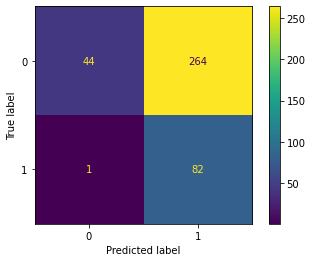

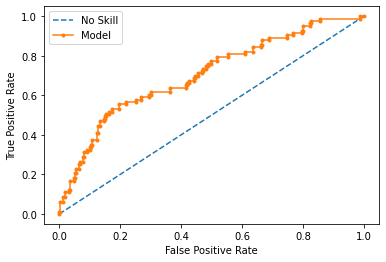

WIAT_word_score_under_85


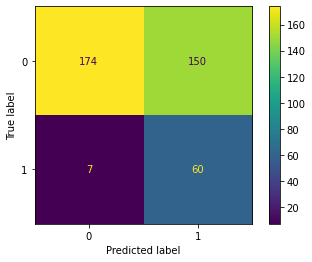

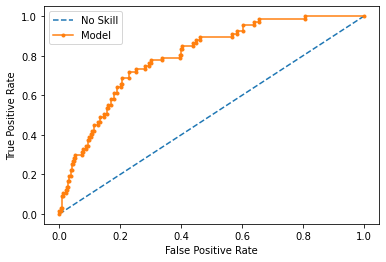

WIAT_FSIQ_bw_70_85


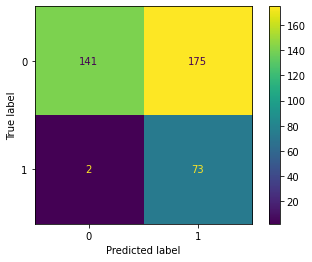

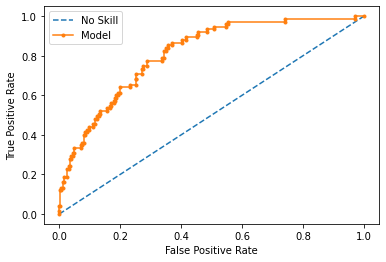

,Diag,TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LR+,LR-,DOR,F1,FBeta,MCC,BM,MK,ROC AUC
2,WIAT_FSIQ_bw_70_85,73.01,141.01,175.01,2.01,0.63,0.5473,0.2944,0.9859,0.7056,0.0141,1.0,1.0,0.9732,0.5538,0.0268,0.4462,1.0,1.0,1.7573,0.0601,29,0.4521,0.7909,0.3429,0.4194,0.2803,0.811814
1,WIAT_word_score_under_85,60.01,174.01,150.01,7.01,0.54,0.5985,0.2857,0.9613,0.7143,0.0387,1.0,1.0,0.8954,0.4630,0.1046,0.5370,1.0,1.0,1.9339,0.1948,10,0.4332,0.7379,0.3268,0.4324,0.2470,0.798554
0,WIAT_num_score_under_85,82.01,44.01,264.01,1.01,0.88,0.3223,0.2370,0.9776,0.7630,0.0224,1.0,1.0,0.9878,0.8571,0.0122,0.1429,1.0,1.0,1.1525,0.0854,13,0.3823,0.7502,0.1675,0.1307,0.2146,0.706580


In [15]:
# Check performance of the final model on validation set for all models

results_val_set = []
for diag in diag_cols:
    if item_lvl_w_imp[diag].sum() > 50:
        classifier = best_classifiers[diag][0]
        threshold = best_thresholds[diag]
        metrics = get_metrics(classifier, threshold, diag, input_cols, 'validation', 1)
        prevalence = item_lvl_w_imp[diag].sum()/len(item_lvl_w_imp)
        results_val_set.append([
            diag, 
            *metrics])
restults_val_set_df = pd.DataFrame(results_val_set, columns=["Diag"]+metric_names+["ROC AUC"])
restults_val_set_df.sort_values(by="ROC AUC", ascending=False)

In [16]:
# Do cross-validation to get more reliable ROC AUC scores (f1 harder to obtain with cross validation - need to change threshold)

auc_cv_mean_val_set = []
auc_cv_std_val_set = []
for diag in diag_cols:
    if item_lvl_w_imp[diag].sum() > 50:
        classifier = best_classifiers[diag][0]
        
        cv = StratifiedKFold(n_splits=5)
        auc = cross_val_score(classifier, train_set[input_cols], train_set[diag], cv=cv, scoring='roc_auc', n_jobs=-1)
        
        auc_cv_mean_val_set.append(auc.mean())
        auc_cv_std_val_set.append(auc.std())
restults_val_set_df["ROC AUC Mean CV"] = pd.Series(auc_cv_mean_val_set)
restults_val_set_df["ROC AUC Std CV"] = pd.Series(auc_cv_std_val_set)
restults_val_set_df

,Diag,TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LR+,LR-,DOR,F1,FBeta,MCC,BM,MK,ROC AUC,ROC AUC Mean CV,ROC AUC Std CV
0,WIAT_num_score_under_85,82.01,44.01,264.01,1.01,0.88,0.3223,0.2370,0.9776,0.7630,0.0224,1.0,1.0,0.9878,0.8571,0.0122,0.1429,1.0,1.0,1.1525,0.0854,13,0.3823,0.7502,0.1675,0.1307,0.2146,0.706580,0.754281,0.044177
1,WIAT_word_score_under_85,60.01,174.01,150.01,7.01,0.54,0.5985,0.2857,0.9613,0.7143,0.0387,1.0,1.0,0.8954,0.4630,0.1046,0.5370,1.0,1.0,1.9339,0.1948,10,0.4332,0.7379,0.3268,0.4324,0.2470,0.798554,0.790407,0.022200
2,WIAT_FSIQ_bw_70_85,73.01,141.01,175.01,2.01,0.63,0.5473,0.2944,0.9859,0.7056,0.0141,1.0,1.0,0.9732,0.5538,0.0268,0.4462,1.0,1.0,1.7573,0.0601,29,0.4521,0.7909,0.3429,0.4194,0.2803,0.811814,0.814418,0.022131


WIAT_num_score_under_85


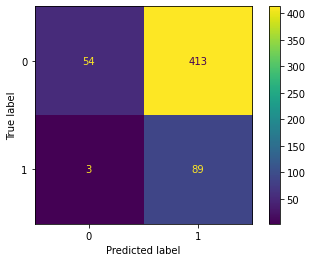

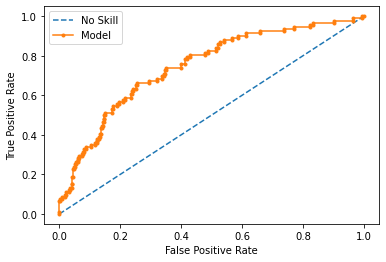

WIAT_word_score_under_85


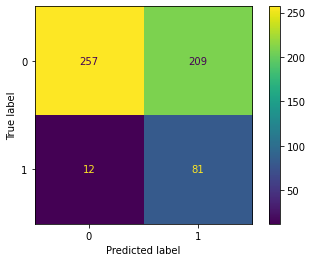

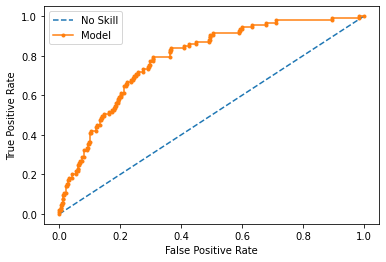

WIAT_FSIQ_bw_70_85


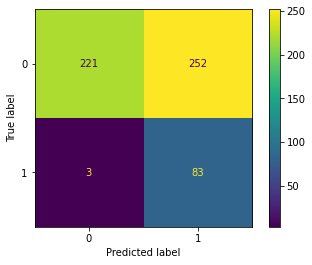

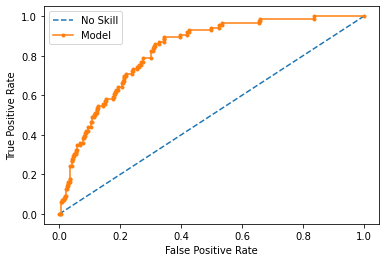

,Diag,TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LR+,LR-,DOR,F1,FBeta,MCC,BM,MK,ROC AUC
0,WIAT_num_score_under_85,89.01,54.01,413.01,3.01,0.90,0.2558,0.1773,0.9472,0.8227,0.0528,1.0,1.0,0.9673,0.8844,0.0327,0.1156,1.0,1.0,1.0937,0.2829,4,0.2997,0.6691,0.1016,0.0829,0.1245,0.747579
1,WIAT_word_score_under_85,81.01,257.01,209.01,12.01,0.52,0.6046,0.2793,0.9554,0.7207,0.0446,1.0,1.0,0.8709,0.4485,0.1291,0.5515,1.0,1.0,1.9418,0.2341,8,0.4230,0.7187,0.3148,0.4224,0.2347,0.788154
2,WIAT_FSIQ_bw_70_85,83.01,221.01,252.01,3.01,0.60,0.5438,0.2478,0.9866,0.7522,0.0134,1.0,1.0,0.9650,0.5328,0.0350,0.4672,1.0,1.0,1.8112,0.0749,24,0.3943,0.7484,0.3183,0.4322,0.2344,0.827474


In [17]:
# Check performance of the final model on test set for all models

results_test_set = []
for diag in diag_cols:
    if item_lvl_w_imp[diag].sum() > 50:
        classifier = best_classifiers[diag][0]
        threshold = best_thresholds[diag]
        metrics = get_metrics(classifier, threshold, diag, input_cols, 'test', 1)
        prevalence = item_lvl_w_imp[diag].sum()/len(item_lvl_w_imp)
        results_test_set.append([
            diag, 
            *metrics])
restults_test_set_df = pd.DataFrame(results_test_set, columns=["Diag"]+metric_names+["ROC AUC"])
restults_test_set_df

### Feature importance

In [18]:
# Only use well performing diagnoses for feature selection: with (Mean CV AUC - Mean CV Std) > 0.65 and F1 Beta > 0.5

diags_with_good_performance = list(restults_val_set_df[((restults_val_set_df["ROC AUC Mean CV"] - restults_val_set_df["ROC AUC Std CV"])>0.65) & (restults_val_set_df["FBeta"] > 0.5)]["Diag"])
display(diags_with_good_performance)
len(diags_with_good_performance)

['WIAT_num_score_under_85', 'WIAT_word_score_under_85', 'WIAT_FSIQ_bw_70_85']

3

In [19]:
if IMPORTANCES_FROM_FILE == 1:
    forward_feature_objects = {}
    backward_feature_objects = {}
    try:
        forward_feature_objects = load('forward-sfs-thresholds-item-lvl.joblib')
    except Exception as e: print(e)

In [20]:
# Find elbow of the curve (draw a line from the first to the last point of the curve and then find the data point that is farthest away from that line) https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve 
def find_elbow(curve):
    from numpy import matlib 
    n_points = len(curve)
    all_coord = np.vstack((range(n_points), curve)).T
    first_point = all_coord[0]
    line_vec = all_coord[-1] - all_coord[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    vec_from_first = all_coord - first_point
    scalar_product = np.sum(vec_from_first * np.matlib.repmat(line_vec_norm, n_points, 1), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    dist_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    idx_of_best_point = np.argmax(dist_to_line)
    return idx_of_best_point + 1

def analyze_importances(importances):
    importances_list = []
    for key in importances:
        importances_list.append(importances[key]['avg_score'])
    importances_df = pd.DataFrame(importances_list, index=importances.keys(), columns=["ROC AUC"])
    display(importances_df)

    max_score = max(importances_list)
    n_cols_max_score = importances_df[importances_df["ROC AUC"] == max_score].index[0]
    print("Max score: ", max_score, " at ", n_cols_max_score, " features")
    features_up_to_max_score = importances[n_cols_max_score]["feature_names"]

    plt.figure(figsize=(16,8))
    plt.plot(importances_df)
    plt.xticks(np.arange(1,100, 3))
    plt.vlines(np.arange(1,100, 3), ymin=min(importances_list), ymax=max(importances_list), colors='purple', ls=':', lw=1)
    plt.show()
    
    optimal_nb_features = find_elbow(importances_list)
    print("Optimal number of features: ", optimal_nb_features)
    
    features_up_to_optimal = importances[optimal_nb_features]["feature_names"]
    display(features_up_to_optimal)
    
    return (features_up_to_optimal, features_up_to_max_score)

WIAT_num_score_under_85


,ROC AUC
1,0.657254
2,0.676520
3,0.698603
4,0.732580
5,0.748739
...,...
96,0.797635
97,0.798164
98,0.797952
99,0.797473


Max score:  0.8052422527750355  at  59  features


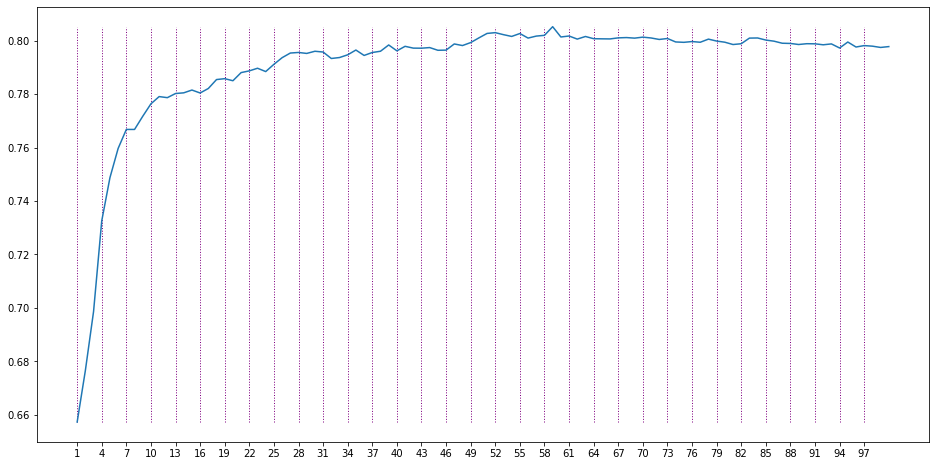

Optimal number of features:  11


('Basic_Demos,Age',
 'SCQ,SCQ_09',
 'SCQ,SCQ_21',
 'SCQ,SCQ_25',
 'SCQ,SCQ_36',
 'CBCL,CBCL_61',
 'ESWAN,DMDD_9B',
 'CIS_P,CIS_P_02',
 'PSI,PSI_17',
 'PSI,PSI_18',
 'WHODAS_SR,WHODAS_SR_01')

WIAT_word_score_under_85


,ROC AUC
1,0.688941
2,0.725838
3,0.740564
4,0.757324
5,0.773683
...,...
96,0.842630
97,0.841054
98,0.843653
99,0.842634


Max score:  0.8453934944559944  at  94  features


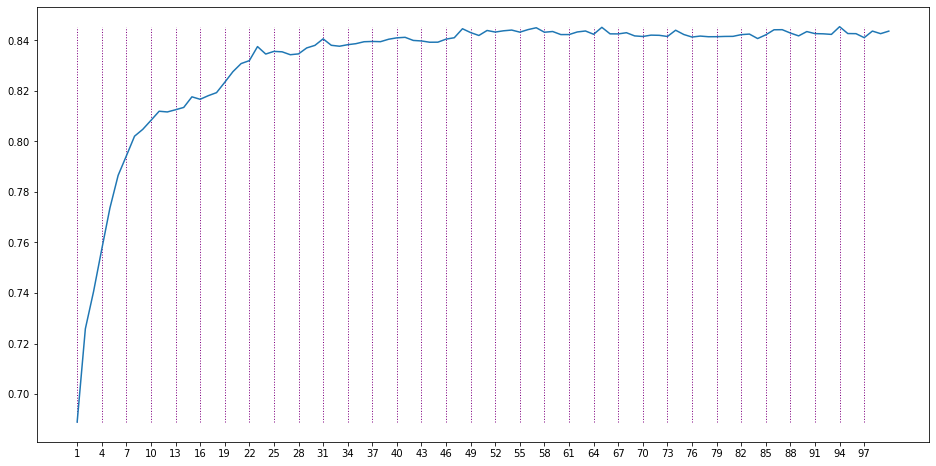

Optimal number of features:  23


('SympChck,CSC_06P',
 'SympChck,CSC_27P',
 'SCQ,SCQ_05',
 'SCQ,SCQ_18',
 'SCQ,SCQ_40',
 'ASSQ,ASSQ_08',
 'SDQ,SDQ_14',
 'SDQ,SDQ_27',
 'SDQ,SDQ_30',
 'CBCL,CBCL_37',
 'CBCL,CBCL_61',
 'APQ_P,APQ_P_31',
 'PCIAT,PCIAT_03',
 'ESWAN,MDD_2A',
 'MFQ_P,MFQ_P_19',
 'APQ_SR,APQ_SR_08',
 'APQ_SR,APQ_SR_12',
 'APQ_SR,APQ_SR_16',
 'PSI,PSI_18',
 'PSI,PSI_22',
 'PSI,PSI_34',
 'WHODAS_SR,WHODAS_SR_01',
 'APQ_SR,APQ_SR_26A_WAS_MISSING')

WIAT_FSIQ_bw_70_85


,ROC AUC
1,0.693525
2,0.737842
3,0.768506
4,0.786480
5,0.799221
...,...
96,0.867443
97,0.867417
98,0.867552
99,0.867330


Max score:  0.8695343617658353  at  31  features


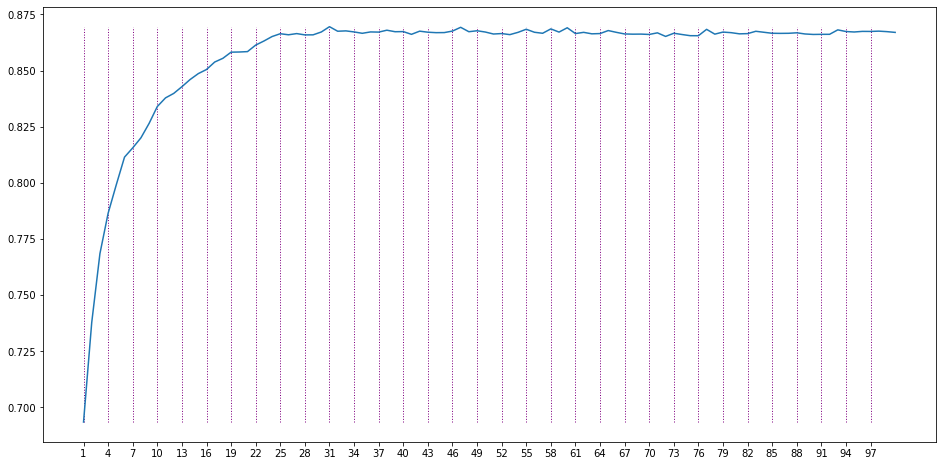

Optimal number of features:  19


('Basic_Demos,Sex',
 'SympChck,CSC_36C',
 'SympChck,CSC_41P',
 'SCQ,SCQ_05',
 'SCQ,SCQ_39',
 'ASSQ,ASSQ_21',
 'SDQ,SDQ_20',
 'SWAN,SWAN_03',
 'CBCL,CBCL_49',
 'CBCL,CBCL_79',
 'ICU_P,ICU_P_15',
 'APQ_P,APQ_P_13',
 'APQ_P,APQ_P_29',
 'MFQ_P,MFQ_P_14',
 'APQ_SR,APQ_SR_11',
 'PSI,PSI_01',
 'PSI,PSI_18',
 'PSI,PSI_31',
 'CIS_SR,CIS_SR_04')

In [21]:
from mlxtend.feature_selection import SequentialFeatureSelector

if IMPORTANCES_FROM_FILE == 0:
    forward_feature_subsets = {}
    forward_feature_objects = {}
    for diag in diags_with_good_performance: 
        print(diag)
        diag_classifier = best_classifiers[diag][0]

        cv = StratifiedKFold(n_splits=3)
        sfs = SequentialFeatureSelector(diag_classifier, 
              k_features=100,
              forward=True, 
              scoring='roc_auc',
              cv=cv,
              n_jobs=-1)

        sfs = sfs.fit(train_set[input_cols], train_set[diag])

        forward_feature_subsets[diag] = sfs.subsets_
        forward_feature_objects[diag] = sfs
        
        analyze_importances(forward_feature_objects[diag].subsets_)

In [22]:
# Save importances to file
if IMPORTANCES_FROM_FILE == 0:
    dump(forward_feature_objects, 'forward-sfs-thresholds-item-lvl.joblib', compress=1)

WIAT_num_score_under_85


,ROC AUC
1,0.657254
2,0.676520
3,0.698603
4,0.732580
5,0.748739
...,...
96,0.797635
97,0.798164
98,0.797952
99,0.797473


Max score:  0.8052422527750355  at  59  features


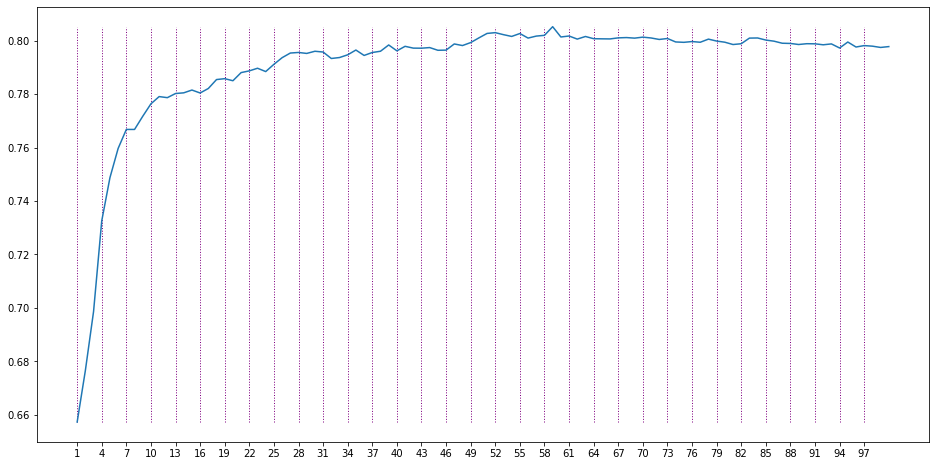

Optimal number of features:  11


('Basic_Demos,Age',
 'SCQ,SCQ_09',
 'SCQ,SCQ_21',
 'SCQ,SCQ_25',
 'SCQ,SCQ_36',
 'CBCL,CBCL_61',
 'ESWAN,DMDD_9B',
 'CIS_P,CIS_P_02',
 'PSI,PSI_17',
 'PSI,PSI_18',
 'WHODAS_SR,WHODAS_SR_01')

Score using all features: 
WIAT_num_score_under_85


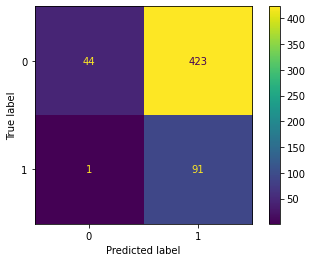

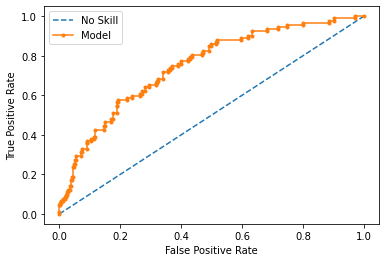

ROC AUC:  0.7493948421934643
Recall:  0.989
Precision:  0.1771
Performance on test set using optimal number of columns: 
WIAT_num_score_under_85


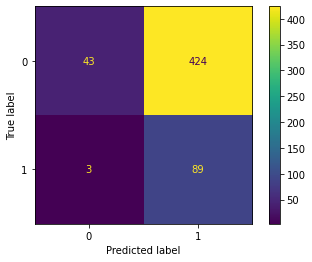

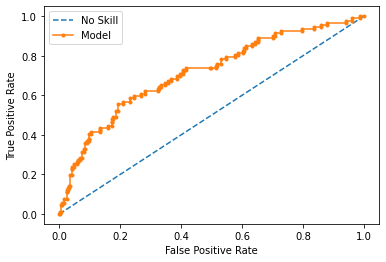

ROC AUC:  0.7149706731216832
Recall:  0.9673
Precision:  0.1735
Performance on test set using number of columns with maximum score
WIAT_num_score_under_85


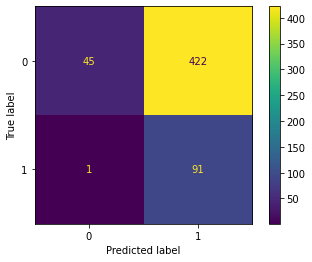

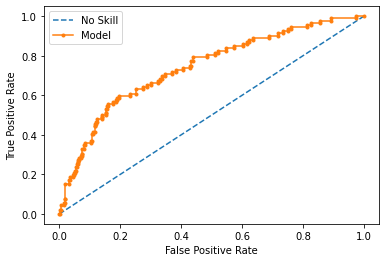

ROC AUC:  0.7416674425100083
Recall:  0.989
Precision:  0.1774
WIAT_word_score_under_85


,ROC AUC
1,0.688941
2,0.725838
3,0.740564
4,0.757324
5,0.773683
...,...
96,0.842630
97,0.841054
98,0.843653
99,0.842634


Max score:  0.8453934944559944  at  94  features


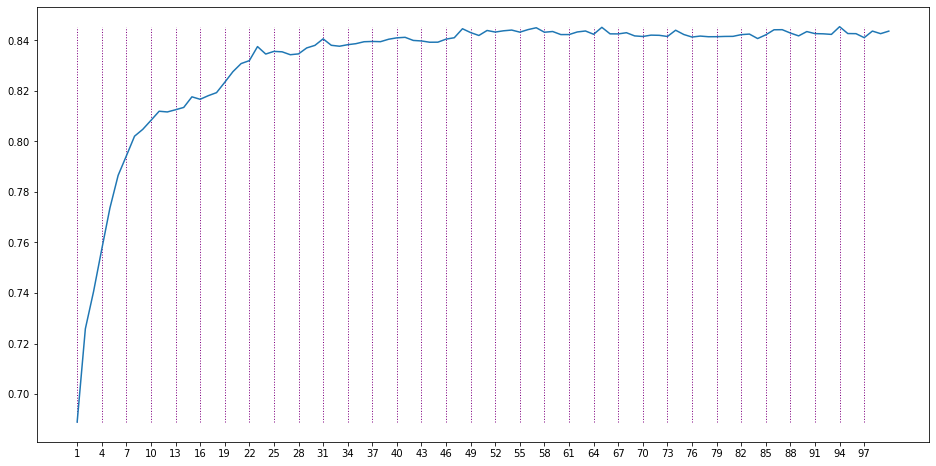

Optimal number of features:  23


('SympChck,CSC_06P',
 'SympChck,CSC_27P',
 'SCQ,SCQ_05',
 'SCQ,SCQ_18',
 'SCQ,SCQ_40',
 'ASSQ,ASSQ_08',
 'SDQ,SDQ_14',
 'SDQ,SDQ_27',
 'SDQ,SDQ_30',
 'CBCL,CBCL_37',
 'CBCL,CBCL_61',
 'APQ_P,APQ_P_31',
 'PCIAT,PCIAT_03',
 'ESWAN,MDD_2A',
 'MFQ_P,MFQ_P_19',
 'APQ_SR,APQ_SR_08',
 'APQ_SR,APQ_SR_12',
 'APQ_SR,APQ_SR_16',
 'PSI,PSI_18',
 'PSI,PSI_22',
 'PSI,PSI_34',
 'WHODAS_SR,WHODAS_SR_01',
 'APQ_SR,APQ_SR_26A_WAS_MISSING')

Score using all features: 
WIAT_word_score_under_85


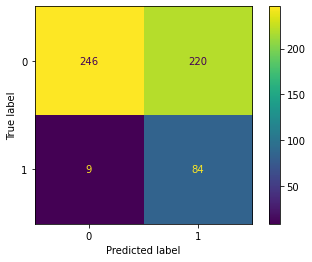

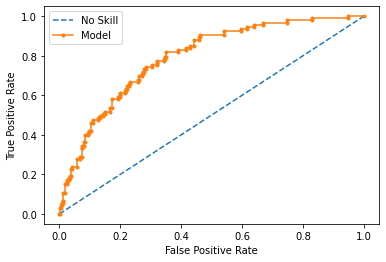

ROC AUC:  0.7920993123817435
Recall:  0.9031
Precision:  0.2763
Performance on test set using optimal number of columns: 
WIAT_word_score_under_85


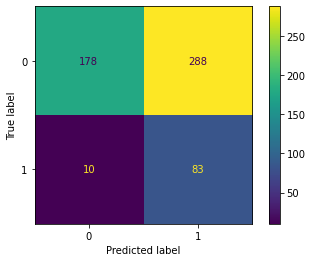

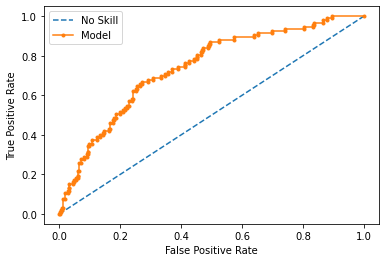

ROC AUC:  0.7404125709538973
Recall:  0.8924
Precision:  0.2237
Performance on test set using number of columns with maximum score
WIAT_word_score_under_85


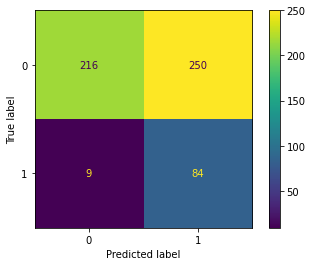

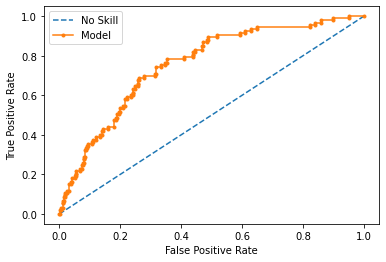

ROC AUC:  0.757949143938345
Recall:  0.9031
Precision:  0.2515
WIAT_FSIQ_bw_70_85


,ROC AUC
1,0.693525
2,0.737842
3,0.768506
4,0.786480
5,0.799221
...,...
96,0.867443
97,0.867417
98,0.867552
99,0.867330


Max score:  0.8695343617658353  at  31  features


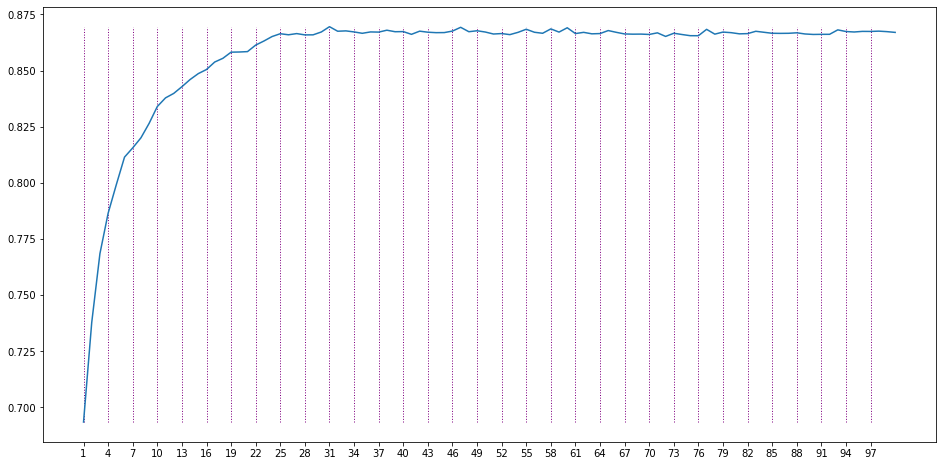

Optimal number of features:  19


('Basic_Demos,Sex',
 'SympChck,CSC_36C',
 'SympChck,CSC_41P',
 'SCQ,SCQ_05',
 'SCQ,SCQ_39',
 'ASSQ,ASSQ_21',
 'SDQ,SDQ_20',
 'SWAN,SWAN_03',
 'CBCL,CBCL_49',
 'CBCL,CBCL_79',
 'ICU_P,ICU_P_15',
 'APQ_P,APQ_P_13',
 'APQ_P,APQ_P_29',
 'MFQ_P,MFQ_P_14',
 'APQ_SR,APQ_SR_11',
 'PSI,PSI_01',
 'PSI,PSI_18',
 'PSI,PSI_31',
 'CIS_SR,CIS_SR_04')

Score using all features: 
WIAT_FSIQ_bw_70_85


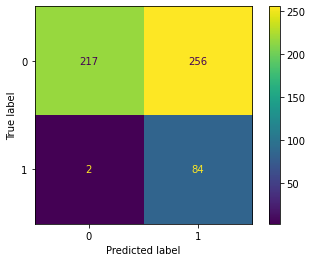

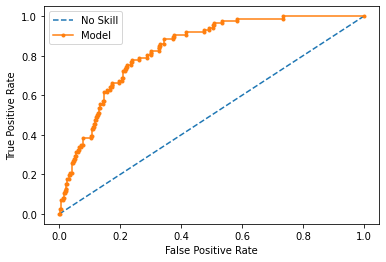

ROC AUC:  0.8337922218398152
Recall:  0.9766
Precision:  0.2471
Performance on test set using optimal number of columns: 
WIAT_FSIQ_bw_70_85


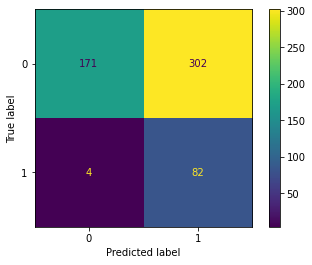

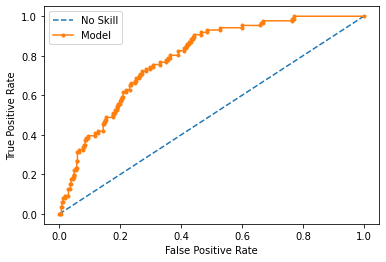

ROC AUC:  0.7906362161364865
Recall:  0.9534
Precision:  0.2136
Performance on test set using number of columns with maximum score
WIAT_FSIQ_bw_70_85


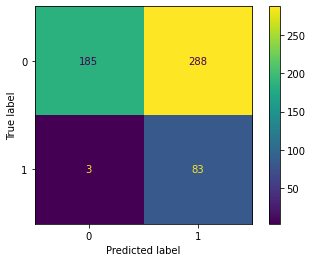

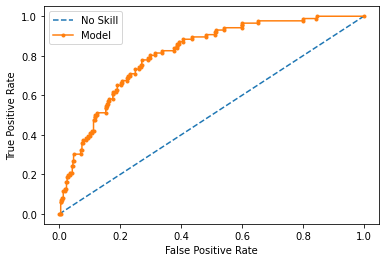

ROC AUC:  0.8112124489896259
Recall:  0.965
Precision:  0.2237


In [24]:
# Print sfs results
for diag in forward_feature_objects.keys():
    print(diag)
    
    features_up_to_optimal, features_up_to_max_score = analyze_importances(forward_feature_objects[diag].subsets_)
    features_up_to_optimal = list(features_up_to_optimal)
    features_up_to_max_score = list(features_up_to_max_score)
    
    # Test both subsets on test set
    classifier = best_classifiers[diag][0]
    threshold = best_thresholds[diag]
    
    # All features
    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_classifier = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), classifier[2])
    new_classifier.fit(train_set[input_cols], train_set[diag])
    print("Score using all features: ")
    metrics = get_metrics(new_classifier, threshold, diag, input_cols, 'test', 1)
    print("ROC AUC: ", metrics[-1])
    print("Recall: ", metrics[metric_names.index("Recall")])
    print("Precision: ", metrics[metric_names.index("Precision")])
    
    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_classifier = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), classifier[2])
    new_classifier.fit(train_set[features_up_to_optimal], train_set[diag])
    print("Performance on test set using optimal number of columns: ")
    metrics = get_metrics(new_classifier, threshold, diag, features_up_to_optimal, 'test', 1)
    print("ROC AUC: ", metrics[-1])
    print("Recall: ", metrics[metric_names.index("Recall")])
    print("Precision: ", metrics[metric_names.index("Precision")])

    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_classifier = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), classifier[2])
    new_classifier.fit(train_set[features_up_to_max_score], train_set[diag])
    print("Performance on test set using number of columns with maximum score")
    metrics = get_metrics(new_classifier, threshold, diag, features_up_to_max_score, 'test', 1)
    print("ROC AUC: ", metrics[-1])
    print("Recall: ", metrics[metric_names.index("Recall")])
    print("Precision: ", metrics[metric_names.index("Precision")])